<a href="https://colab.research.google.com/github/Kevin-Lyy/CVFinalProject/blob/master/lego_voxels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/Kevin-Lyy/CVFinalProject

image data
https://aloi.science.uva.nl/

k3d 
https://k3d-jupyter.org/index.html#

colorize voxels, visualization 
https://github.com/marcomusy/vedo



medium, automated voxel modelling from 3d point cloud 
https://towardsdatascience.com/how-to-automate-voxel-modelling-of-3d-point-cloud-with-python-459f4d43a227

https://colab.research.google.com/drive/1IKzn--AoTBPhH60Y5A7ldcZuyQB21Eqc?usp=sharing

https://www.kaggle.com/code/kmader/pyntcloud-voxel-grids/notebook



## imports

In [ ]:
!pip install ipywidgets
!pip install k3d
!pip install open3d
!pip install pyntcloud
!pip install pyvista
!pip install PVGeo

In [ ]:
!pip install pythreejs
!pip install itkwidgets
!pip install pyyaml

In [ ]:
!pip install jupyterlab

In [ ]:
import math
import random 
import urllib.request
import colorsys

import numpy as np
from scipy.spatial.distance import cdist

import cv2
from google.colab.patches import cv2_imshow
import imutils

import k3d
import open3d as o3d
from pyntcloud import PyntCloud

In [ ]:
import matplotlib.pyplot as plt

import plotly.graph_objects as go

import pyvista as pv
import PVGeo
import pythreejs

In [ ]:
from ipywidgets import widgets
from google.colab import output
output.enable_custom_widget_manager()

from IPython.display import IFrame, HTML

# setup

In [ ]:
!wget https://raw.githubusercontent.com/PointCloudLibrary/pcl/master/test/bunny.pcd
!wget https://raw.githubusercontent.com/Kevin-Lyy/CVFinalProject/master/lego_colors.txt 

--2022-05-17 20:24:53--  https://raw.githubusercontent.com/PointCloudLibrary/pcl/master/test/bunny.pcd
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10878 (11K) [text/plain]
Saving to: ‘bunny.pcd.1’

bunny.pcd.1         100%[===================>]  10.62K  --.-KB/s    in 0s      

2022-05-17 20:24:53 (78.8 MB/s) - ‘bunny.pcd.1’ saved [10878/10878]

--2022-05-17 20:24:53--  https://raw.githubusercontent.com/Kevin-Lyy/CVFinalProject/master/lego_colors.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 240 [text/plain]
Saving to: ‘

In [ ]:
!wget --ignore-length http://aloi.science.uva.nl/tars/aloi_mask4.tar
!tar -x /content/aloi_mask4.tar

URL transformed to HTTPS due to an HSTS policy
--2022-05-17 20:24:53--  https://aloi.science.uva.nl/tars/aloi_mask4.tar
Resolving aloi.science.uva.nl (aloi.science.uva.nl)... 146.50.31.28
Connecting to aloi.science.uva.nl (aloi.science.uva.nl)|146.50.31.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: ignored [application/octet-stream]
Saving to: ‘aloi_mask4.tar.1’

aloi_mask4.tar.1        [             <=>    ]  75.35M  25.3MB/s    in 3.0s    

2022-05-17 20:24:57 (25.3 MB/s) - ‘aloi_mask4.tar.1’ saved [79005696]

tar: Refusing to read archive contents from terminal (missing -f option?)
tar: Error is not recoverable: exiting now


In [ ]:
!wget --ignore-length http://aloi.science.uva.nl/tars/...tar

URL transformed to HTTPS due to an HSTS policy
--2022-05-17 20:24:57--  https://aloi.science.uva.nl/tars/...tar
Resolving aloi.science.uva.nl (aloi.science.uva.nl)... 146.50.31.28
Connecting to aloi.science.uva.nl (aloi.science.uva.nl)|146.50.31.28|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-05-17 20:24:57 ERROR 404: Not Found.



# util

In [ ]:
def img_from_url (url):
    url_response = urllib.request.urlopen(url)
    return cv2.imdecode(np.array(bytearray(url_response.read()), dtype=np.uint8), -1)

## color

In [ ]:
def hex_to_rgb(hex):
    return tuple(int(hex[i:i+2], 16) for i in (0, 2, 4)) 

def rgb_to_hex(r, g, b):
    return ('{:X}{:X}{:X}').format(r, g, b)

def rgb_to_hsv(rgb):
    return colorsys.rgb_to_hsv(*rgb)

def hsv_to_rgb(hsv):
    return colorsys.hsv_to_rgb(*hsv)

## lego

In [ ]:
def get_lego_colors(file_path='lego_colors.txt', dct=False):
    data = open(file_path,'r')
    if dct: 
        return {hex_to_rgb(color.strip()): color.strip() for color in data.readlines()}
    return [hex_to_rgb(color.strip()) for color in data.readlines()]

lego_colors = get_lego_colors()
lego_color_dict = get_lego_colors(dct=True)

In [ ]:
for color in sorted(lego_color_dict, key=lambda x: colorsys.rgb_to_hsv(*x)[0]):
    #print(color, lego_color_dict[color])
    #cv2_imshow(np.full((100, 100, 3), (color)))
    pass

In [ ]:
def recolor_lego(img, valid_colors=lego_colors, resize=False):
    if not resize: 
        img = img.copy().astype('uint8')
    else:
        img = cv2.resize(img.astype('uint8'),(100,100))
        
    valid_colors = np.asarray(valid_colors)
    out = valid_colors[cdist(img.reshape(-1,3),valid_colors).argmin(1)].reshape(img.shape)
    # cv2_imshow(imutils.resize(out.astype('uint8'),width=300))
    return out 

## 3d 

In [ ]:
def visible_axes(b=True):
    return {'xaxis': {'visible': b}, 'yaxis': {'visible': b}, 'zaxis': {'visible': b}, 'aspectmode':'data',}

    margin=dict(l=0, r=0, b=0, t=0)

In [ ]:
def draw_geometries(geometries):
    graph_objects = []
    view_axes=True

    for geometry in geometries:
        geometry_type = geometry.get_geometry_type()
        
        if geometry_type == o3d.geometry.Geometry.Type.PointCloud:
            points = np.asarray(geometry.points)
            colors = None
            if geometry.has_colors():
                colors = np.asarray(geometry.colors)
            elif geometry.has_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.normals) * 0.5
            else:
                geometry.paint_uniform_color((1.0, 0.0, 0.0))
                colors = np.asarray(geometry.colors)

            scatter_3d = go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], 
                                      mode='markers', marker=dict(size=1, color=colors))
            graph_objects.append(scatter_3d)

        if geometry_type == o3d.geometry.Geometry.Type.TriangleMesh:
            triangles = np.asarray(geometry.triangles)
            vertices = np.asarray(geometry.vertices)
            colors = None
            if geometry.has_vertex_colors():
                colors = np.asarray(geometry.vertex_colors)
            elif geometry.has_triangle_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))
            else:
                colors = (1.0, 0.0, 0.0)
            
            mesh_3d = go.Mesh3d(x=vertices[:,0], y=vertices[:,1], z=vertices[:,2], 
                                i=triangles[:,0], j=triangles[:,1], k=triangles[:,2], 
                                facecolor=colors, opacity=1)
            graph_objects.append(mesh_3d)
        
    fig = go.Figure(
        data=graph_objects,
        layout=dict(scene=visible_axes(view_axes))
    )
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    fig.show()

o3d.visualization.draw_geometries = draw_geometries # replace function

In [ ]:
def img_unique_colors(img):
    for color in np.unique(img.reshape(-1, img.shape[-1]),axis=0):
        print(f"{color}\t{len(list(zip(*np.where(np.all(img == color, axis=-1)))))}")
        cv2_imshow(np.full((100, 100, 3), (color)))

# images

0


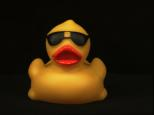

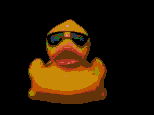




60


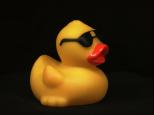

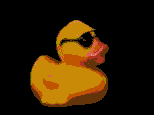




120


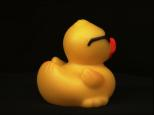

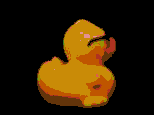




180


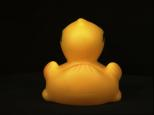

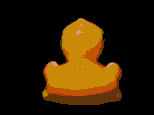




240


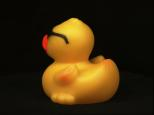

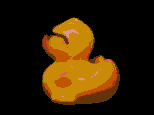




300


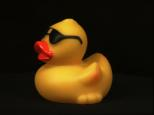

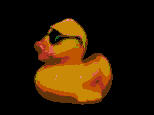

In [ ]:
png4_rot60 = []
png4_rot60_lego = []

for deg in range(6):
    print(deg*60)
    png4_rot60.append(img_from_url(f"https://aloi.science.uva.nl/www-images/62/62_r{deg*60}.jpg"))
    cv2_imshow(png4_rot60[-1])
    png4_rot60_lego.append(recolor_lego(png4_rot60[-1].copy()))
    cv2_imshow(png4_rot60_lego[-1])
    print("\n\n")

In [ ]:
png4_rot60[0].shape

(115, 154, 3)

In [ ]:
png4_rot60[0].shape

(115, 154, 3)

In [ ]:
np.ones([png4_rot60[0].shape[0], png4_rot60[0].shape[1], png4_rot60[0].shape[1]])

array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       ...,

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1.

In [ ]:
assert False

AssertionError: ignored

# code

algorithm for finding legos 

1. isolate by color using `array[np.where(constraint, array)]`
2. find connected components 
3. fit largest legos in going from left to right, then smaller legos  
    `2x1`  
    `1x1`  
4. ??? 
5. profit 



# voxels

In [ ]:
voxels_500 = np.load('/content/points_500.npy')
voxels_500.shape

In [ ]:
voxels_500 = np.load('/content/373_hand_points_500.npy')
voxels_500.shape

(247572, 6)

In [ ]:
cloud = voxels_500[:,:3]
colors = voxels_500[:,3:]
transparent_voxels = voxels_500[np.all(voxels_500[:,3:] != [0, 0, 0], axis=-1)]
valid_colors = np.asarray(lego_colors)
cloud = transparent_voxels[:,:3]
colors = transparent_voxels[:,3:]

In [ ]:
o3_cloud = o3d.geometry.PointCloud()
o3_cloud.points = o3d.utility.Vector3dVector(cloud)
#o3_cloud.colors = o3d.utility.Vector3dVector(np.flip(colors).astype(float))
o3_cloud.colors = o3d.utility.Vector3dVector(colors.astype(float))

pycloud = PyntCloud.from_instance("open3d", o3_cloud)
pycloud.plot(point_size=0.05, opacity=0.1)

voxelgrid_id = pycloud.add_structure("voxelgrid")
voxelgrid = pycloud.structures[voxelgrid_id]


/usr/local/lib/python3.7/dist-packages/pythreejs/traits.py:203: UserWarning:

64-bit data types not supported for WebGL data, casting to 32-bit.



Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(35.72918807810894, 89.84069886947586, 104.46…

In [ ]:
colors = valid_colors[cdist(colors.reshape(-1,3),valid_colors).argmin(1)].reshape(colors.shape)
transparent_voxels = np.hstack((cloud, colors))
transparent_voxels = transparent_voxels[np.all(transparent_voxels[:,3:] != [0, 0, 0], axis=-1)]
cloud = transparent_voxels[:,:3]
colors = transparent_voxels[:,3:]

In [ ]:
cloud = np.empty((0, 3))
colors = np.empty((0, 3))

voxel_img = png4_rot60_lego[0]
for g in range(len(png4_rot60_lego)):
    for i in range(voxel_img.shape[0]):
        for j in range(voxel_img.shape[1]):
            img = png4_rot60_lego[0]
            if (img[i][j] != (5, 19, 29)).all():
                cloud = np.append(cloud, [[i, j, g]], axis=0)
                colors = np.append(colors, [img[i][j][::-1]], axis=0)

    

KeyboardInterrupt: ignored

In [ ]:
convcloud = pycloud.to_instance("open3d", mesh=True)
o3d.visualization.draw_geometries([convcloud])

In [ ]:
voxelgrid.plot(d=3)

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.0, 0.0, 0.0), projectionMatrix=(1.0, 0.0, …

In [ ]:
voxel_img = png4_rot60_lego[0].copy()
print(voxel_img.shape)
cv2_imshow(voxel_img)

print()
voxel_img2 = png4_rot60_lego[-1].copy()
print(voxel_img2.shape)
cv2_imshow(voxel_img2)

In [ ]:
cloud = np.empty((0, 3))
colors = np.empty((0, 3))

for i in range(voxel_img.shape[0]):
    for j in range(voxel_img.shape[1]):
        if (voxel_img[i][j] != (5, 19, 29)).all():
            cloud = np.append(cloud, [[i, j, 0]], axis=0)
            colors = np.append(colors, [voxel_img[i][j][::-1]], axis=0)


for i in range(voxel_img2.shape[0]):
    for j in range(voxel_img2.shape[1]):
        if (voxel_img2[i][j] != (5, 19, 29)).all():
            cloud = np.append(cloud, [[i, j, 2]], axis=0)
            colors = np.append(colors, [voxel_img2[i][j][::-1]], axis=0)

In [ ]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=cloud[:,0], y=cloud[:,1], z=cloud[:,2],
            mode='markers', marker=dict(size=1, color=colors)
        )
    ],
    layout=dict(scene=visible_axes())
)
fig.show()

In [ ]:
voxel_img.shape

In [ ]:
o3d.visualization.draw_geometries([o3_cloud])

In [ ]:
o3d.visualization.draw_geometries([voxelgrid])

In [ ]:
#cloud = o3d.io.read_point_cloud("bunny.pcd")
#cloud = o3_cloud
points = np.asarray(cloud.points)
colors = np.asarray(cloud.colors)

points.shape

In [ ]:
vcloud = o3d.geometry.PointCloud()
vcloud.points = o3d.utility.Vector3dVector(cloud)
vcloud.colors = o3d.utility.Vector3dVector(colors.astype(float) / 255.0)

In [ ]:
vcloud = o3_cloud

In [ ]:
vsize=max(vcloud.get_max_bound()-vcloud.get_min_bound())*.01
# vsize=round(vsize,4)
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(vcloud, voxel_size=vsize)

voxels=voxel_grid.get_voxels()
vox_mesh=o3d.geometry.TriangleMesh()

for v in voxels:
    m = 2
    #cube=o3d.geometry.TriangleMesh.create_box(width=(.78*m), height=(.96*m), depth=(.78*m))
    cube=o3d.geometry.TriangleMesh.create_box(width=1, height=1, depth=1)
    cube.paint_uniform_color(v.color)
    cube.translate(v.grid_index, relative=False)
    vox_mesh+=cube

o3d.visualization.draw_geometries([vox_mesh])